# Conformers and conformational fingerprints

Most molecular fingerprints operate on topological molecular graph. It is a "flat" structure, i.e. only takes into consideration atoms and bonds, without any spatial structure. **Conformers** are 3D structures that approximate the configuration of atoms in space, optimizing for stability and physical feasibility. While this is hard and not always possible, we can get more information this way.

With scikit-fingerprints, generating conformers is very easy with `ConformerGenerator` class ([docs](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.preprocessing.ConformerGenerator.html)). It uses [ETKDGv3 algorithm](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00025), which is a method based on distance geometry, stochastic optimization, and experimental information. It has relatively good speed and performance, and our implementation provides reasonable defaults for its parameters.

`ConformerGenerator` requires `Mol` objects as inputs, and outputs new `PropertyMol` objects with conformer information attached. Selected conformer identifier is saved in `conf_id` property. All hydrogens are also explicitly added, as it's required for proper conformer generation. No in-place changes are made for safety.

Let's generate conformers for molecules from [beta-secretase 1 (BACE) dataset](https://doi.org/10.1021/acs.jcim.6b00290) from MoleculeNet benchmark. Due to computational cost, using `n_jobs=-1` is highly encouraged.

In [1]:
from skfp.datasets.moleculenet import load_bace
from skfp.preprocessing import ConformerGenerator, MolFromSmilesTransformer


smiles_list, y = load_bace()

mol_from_smiles = MolFromSmilesTransformer()
mols = mol_from_smiles.transform(smiles_list)

conf_gen = ConformerGenerator(n_jobs=-1)
mols = conf_gen.transform(mols)

Let's visualize an example molecule and its conformer, using [Py3DMol](https://pypi.org/project/py3Dmol/).

Since returned molecules are regular RDKit `Mol` objects, they are fully interoperable with any other frameworks. scikit-fingerprints brings convenience and speed of multiprocessing.

In [2]:
!pip install --quiet py3Dmol

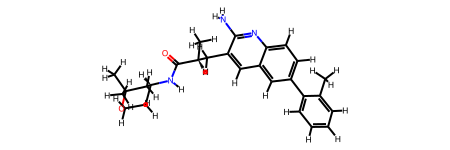

In [3]:
mols[0]

In [4]:
import py3Dmol

from rdkit.Chem import MolToMolBlock

view = py3Dmol.view(
    data=MolToMolBlock(mols[0]),
    style={"stick": {}, "sphere": {"scale": 0.3}}
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Conformational fingerprints

Many fingerprints utilize the 3-dimensional structure of conformers. Many of them come calculate features from distributions of interatomic distances, e.g. [AutocorrFingerprint](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.fingerprints.AutocorrFingerprint.html#skfp.fingerprints.AutocorrFingerprint), [MORSEFingerprint](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.fingerprints.MORSEFingerprint.html) and [RDFFingerprint](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.fingerprints.RDFFingerprint.html). Others work differently, e.g. [E3FPFingerprint](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.fingerprints.E3FPFingerprint.html) uses extension of ECFP fingerprint to 3D "balls" around atoms, summarizing their circular, spatial neighborhoods. Many of those fingerprints are very cheap to compute, just the conformer generation is expensive. Only E3FP has a visibly larger cost.

Let's use a few of them on generated conformers. We will also use pipelines, which you can read more about in tutorial 3.

In [5]:
from skfp.fingerprints import AutocorrFingerprint, E3FPFingerprint, MORSEFingerprint, RDFFingerprint
from skfp.model_selection import scaffold_train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline


mols_train, mols_test, y_train, y_test = scaffold_train_test_split(mols, y, test_size=0.2)

for fp_name, fp_obj in [
    ("Autocorrelation", AutocorrFingerprint(use_3D=True)),
    ("E3FP", E3FPFingerprint(n_jobs=-1)),
    ("MoRSE", MORSEFingerprint()),
    ("RDF", RDFFingerprint()),
]:
    print(fp_name)
    
    pipeline = make_pipeline(
        fp_obj,
        RandomForestClassifier(random_state=0),
    )
    pipeline.fit(mols_train, y_train)
    
    y_pred = pipeline.predict_proba(mols_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred)
    
    print(f"AUROC: {auroc:.2%}")
    print()


Autocorrelation
AUROC: 67.75%

E3FP
AUROC: 76.20%

MoRSE
AUROC: 69.41%

RDF
AUROC: 68.65%



### Parameters for conformer generation

Generating conformers with `ConformerGenerator` is easy with default parameters, which are designed as a reasonable tradeoff between quality, speed, and reliability. They are:
1. Generate 1 conformer per molecule
2. Max 1000 attempts to generate per molecule
3. No force field optimization

In case of optimization failure, as a fallback we try 10x as many iterations and randomized initial coordinates, as it often helps with harder molecules. As a last resort, we also remove enforcing chirality and ignore smoothing failures. If this fails, error is raised by default.

For higher quality, but also at considerably higher computational cost, we can generate more conformers and select the one with the lowest energy (most stable one), and also enable force field optimization like [UFF](https://doi.org/10.1021/ja00051a040) or [MMFF94](https://en.wikipedia.org/wiki/Merck_molecular_force_field).

Let's compare those two options, and also measure the time and classification quality of resulting algorithms. The quality is not necessarily always much higher, but it may be useful if the base case already performs well for a given use case.

In [9]:
from time import time


start = time()
pipeline_default = make_pipeline(
    ConformerGenerator(n_jobs=-1),
    E3FPFingerprint(n_jobs=-1),
    RandomForestClassifier(random_state=0),
)
pipeline_default.fit(mols_train, y_train)
end = time()
y_pred_default = pipeline_default.predict_proba(mols_test)[:, 1]
auroc_default = roc_auc_score(y_test, y_pred_default)
print(f"Default time: {end - start:.2f}")
print(f"AUROC default: {auroc_default:.2%}")

print()

start = time()
pipeline_optimized = make_pipeline(
    ConformerGenerator(num_conformers=3, optimize_force_field="UFF", n_jobs=-1),
    E3FPFingerprint(n_jobs=-1),
    RandomForestClassifier(random_state=0),
)
pipeline_optimized.fit(mols_train, y_train)
end = time()
y_pred_optimized = pipeline_optimized.predict_proba(mols_test)[:, 1]
auroc_optimized = roc_auc_score(y_test, y_pred_optimized)
print(f"Quality-optimized time: {end - start:.2f}")
print(f"AUROC optimized: {auroc_optimized:.2%}")

Default time: 12.41
AUROC default: 76.20%

Quality-optimized time: 44.14
AUROC optimized: 78.69%
